In [157]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px

import seaborn as sns
from sklearn.preprocessing import StandardScaler , MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [158]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

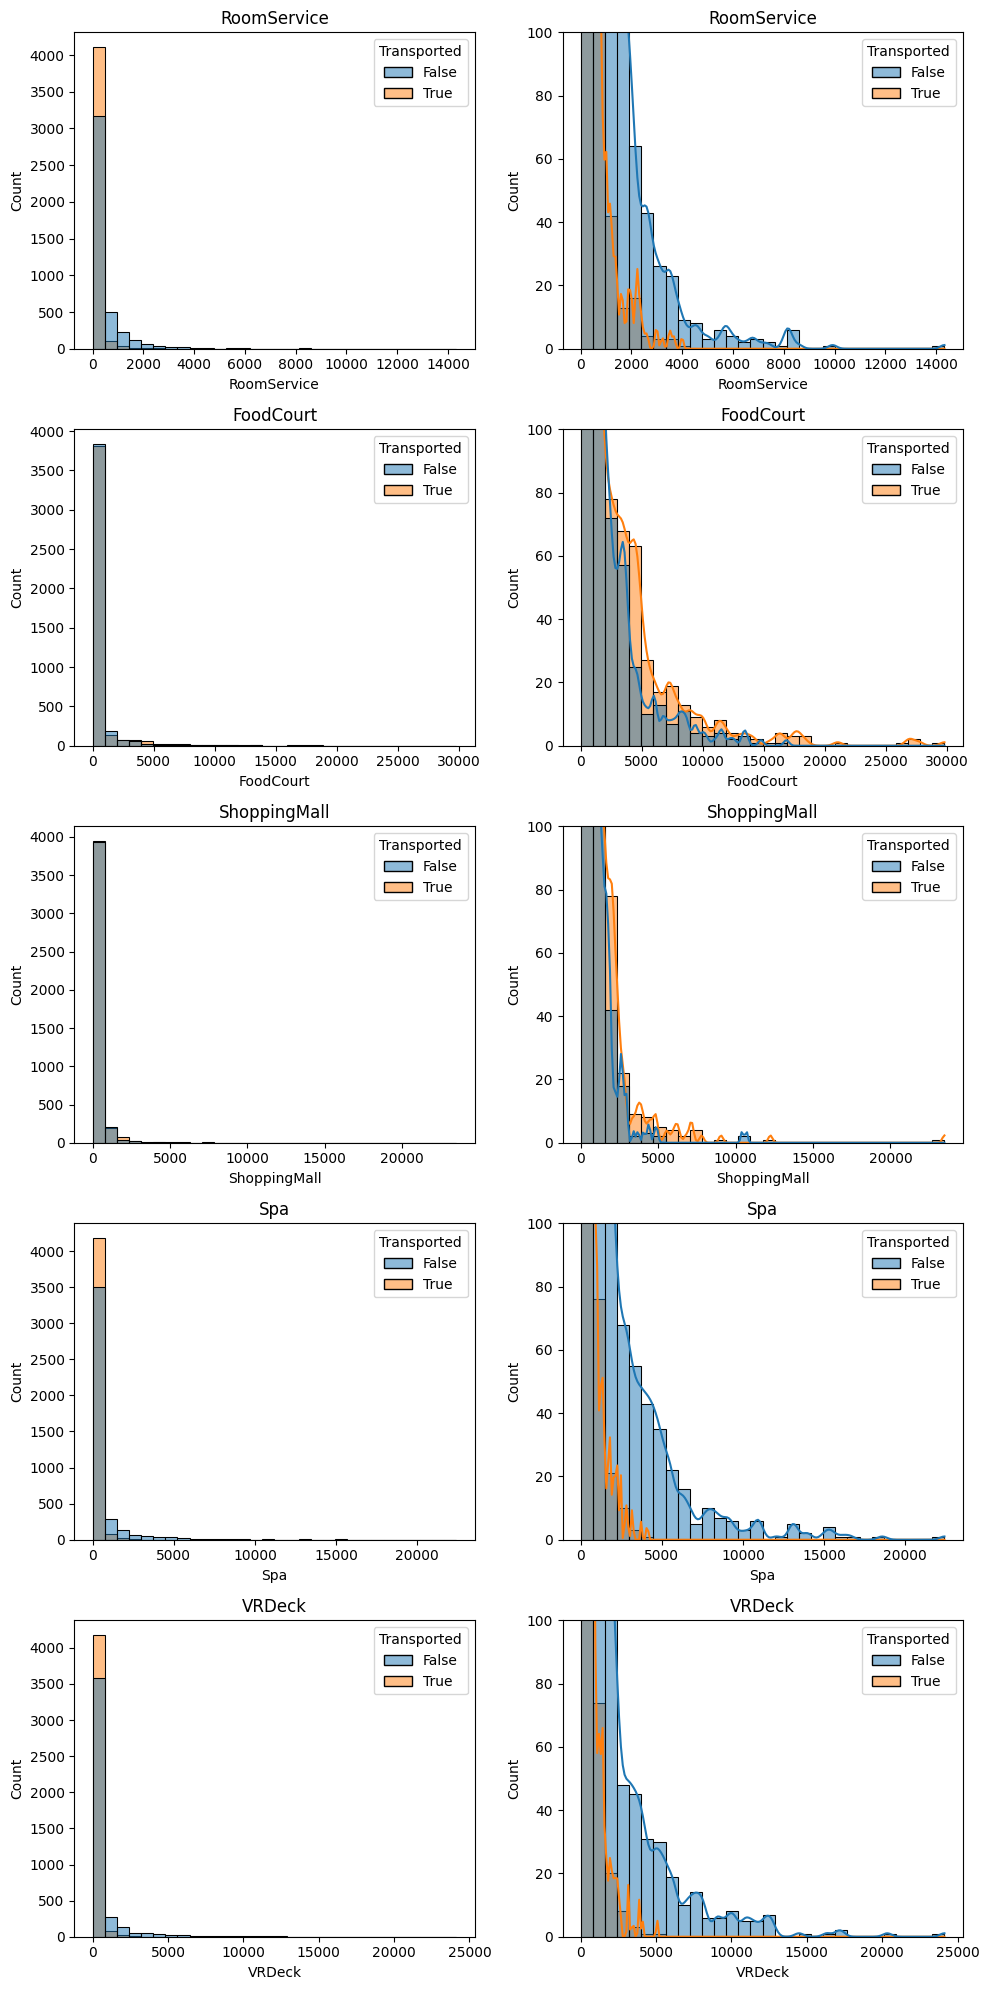

In [159]:
def numericFeatureMetrics(dataset, exp_feats):
    # Plot expenditure features
    fig=plt.figure(figsize=(10,20))
    for i, var_name in enumerate(exp_feats):
        # Left plot
        ax=fig.add_subplot(5,2,2*i+1)
        sns.histplot(data=dataset, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
        ax.set_title(var_name)

        # Right plot (truncated)
        ax=fig.add_subplot(5,2,2*i+2)
        sns.histplot(data=dataset, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
        plt.ylim([0,100])
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit
    plt.show()

exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numericFeatureMetrics(train_df, exp_feats)

In [160]:
numeric_features = train_df.select_dtypes(include=['float64']).columns
numeric_features

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

In [161]:
categorical_features=train_df.select_dtypes(include=['object']).columns
categorical_features

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')

In [162]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [163]:
test_df.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [164]:
def handleNan(data):
    data.drop(columns=['Name'], axis=1, inplace=True)
    data.dropna(inplace=True)

handleNan(train_df)
handleNan(test_df)

train_df.shape

(6764, 13)

In [165]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [166]:
def convertCabin(dataset):
    dataset['cabin_deck'] = dataset['Cabin'].apply(lambda x: x.split('/')[0])
    dataset['cabin_number'] = dataset['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    dataset['cabin_side'] = dataset['Cabin'].apply(lambda x: x.split('/')[2])
    dataset.drop(columns=['Cabin'], axis=1, inplace=True)

convertCabin(train_df)
convertCabin(test_df)

In [167]:
train_df['cabin_number'].astype(int).max()

1894

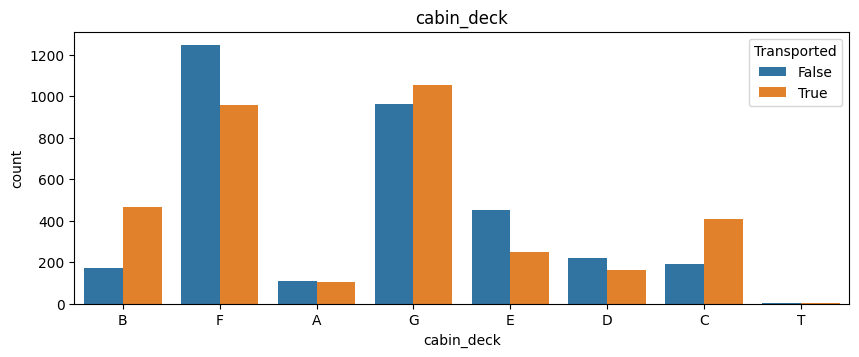

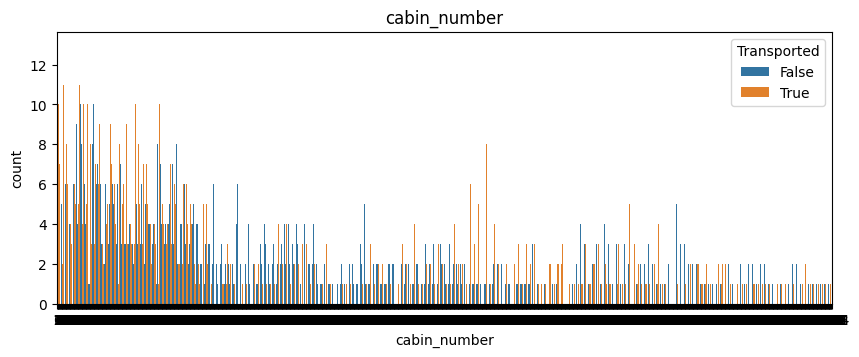

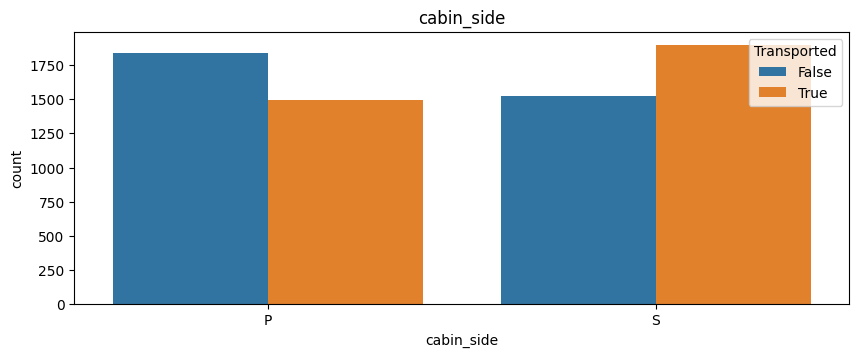

In [168]:

def displayCabinMetrics(dataset, col):
    fig=plt.figure(figsize=(10,12))
    plt.subplot(3,1,1)
    sns.countplot(data=dataset, x=col, hue='Transported')
    plt.title(col)

displayCabinMetrics(train_df, 'cabin_deck')
displayCabinMetrics(train_df, 'cabin_number')
displayCabinMetrics(train_df, 'cabin_side')

# numericFeatureMetrics(train_df, ['Cabin_deck', 'Cabin_number', 'Cabin_side'])

In [169]:
display(train_df['cabin_deck'].isnull().sum())
display(train_df['cabin_number'].isnull().sum())
display(train_df['cabin_side'].isnull().sum())

display(train_df['cabin_deck'].unique().size)
display(train_df['cabin_number'].unique().size)
display(train_df['cabin_side'].unique().size)
display(train_df['HomePlanet'].unique())
display(train_df['Destination'].unique())


0

0

0

8

1744

2

array(['Europa', 'Earth', 'Mars'], dtype=object)

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype=object)

In [170]:
display(test_df['cabin_deck'].isnull().sum())
display(test_df['cabin_number'].isnull().sum())
display(test_df['cabin_side'].isnull().sum())

display(test_df['cabin_deck'].unique().size)
display(test_df['cabin_number'].unique().size)
display(test_df['cabin_side'].unique().size)
display(test_df['HomePlanet'].unique())
display(test_df['Destination'].unique())

0

0

0

8

1381

2

array(['Earth', 'Europa', 'Mars'], dtype=object)

array(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], dtype=object)

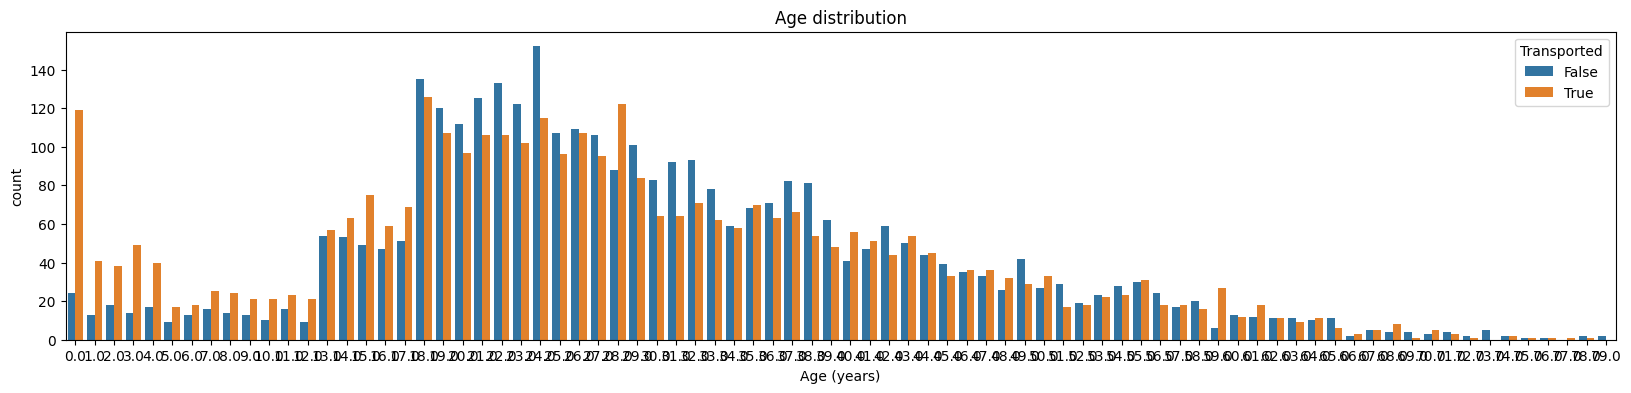

In [171]:
def ageMetrics(dataset):
    plt.figure(figsize=(20,4))
    sns.countplot(data=dataset, x= "Age", hue= 'Transported')
    plt.title('Age distribution')
    plt.xlabel('Age (years)')

ageMetrics(train_df)

In [172]:
def binningAge(dataset):
    dataset['age_group']=''
    dataset.loc[dataset['Age']<=12,'age_group']='Age_0-12'
    dataset.loc[(dataset['Age']>12) & (dataset['Age']<18),'age_group']='Age_13-17'
    dataset.loc[(dataset['Age']>=18) & (dataset['Age']<=25),'age_group']='Age_18-25'
    dataset.loc[(dataset['Age']>25) & (dataset['Age']<=30),'age_group']='Age_26-30'
    dataset.loc[(dataset['Age']>30) & (dataset['Age']<=50),'age_group']='Age_31-50'
    dataset.loc[dataset['Age']>50,'age_group']='Age_51+'

binningAge(train_df)
binningAge(test_df)

# train_df.select_dtypes(include=['float64']).columns

In [173]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_deck,cabin_number,cabin_side,age_group
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Age_31-50
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Age_18-25
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Age_51+
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Age_31-50
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Age_13-17


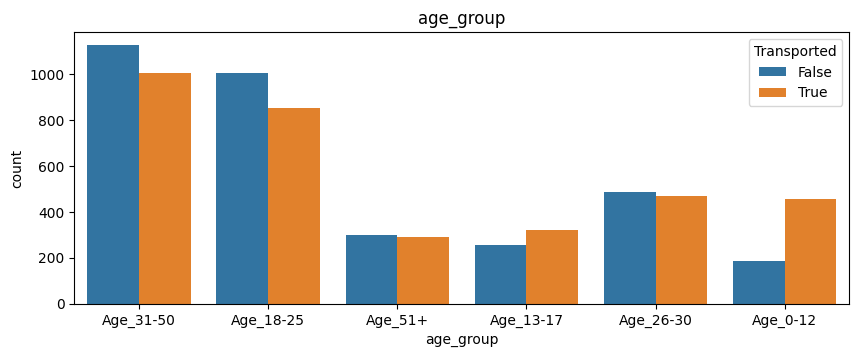

In [174]:
displayCabinMetrics(train_df, 'age_group')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


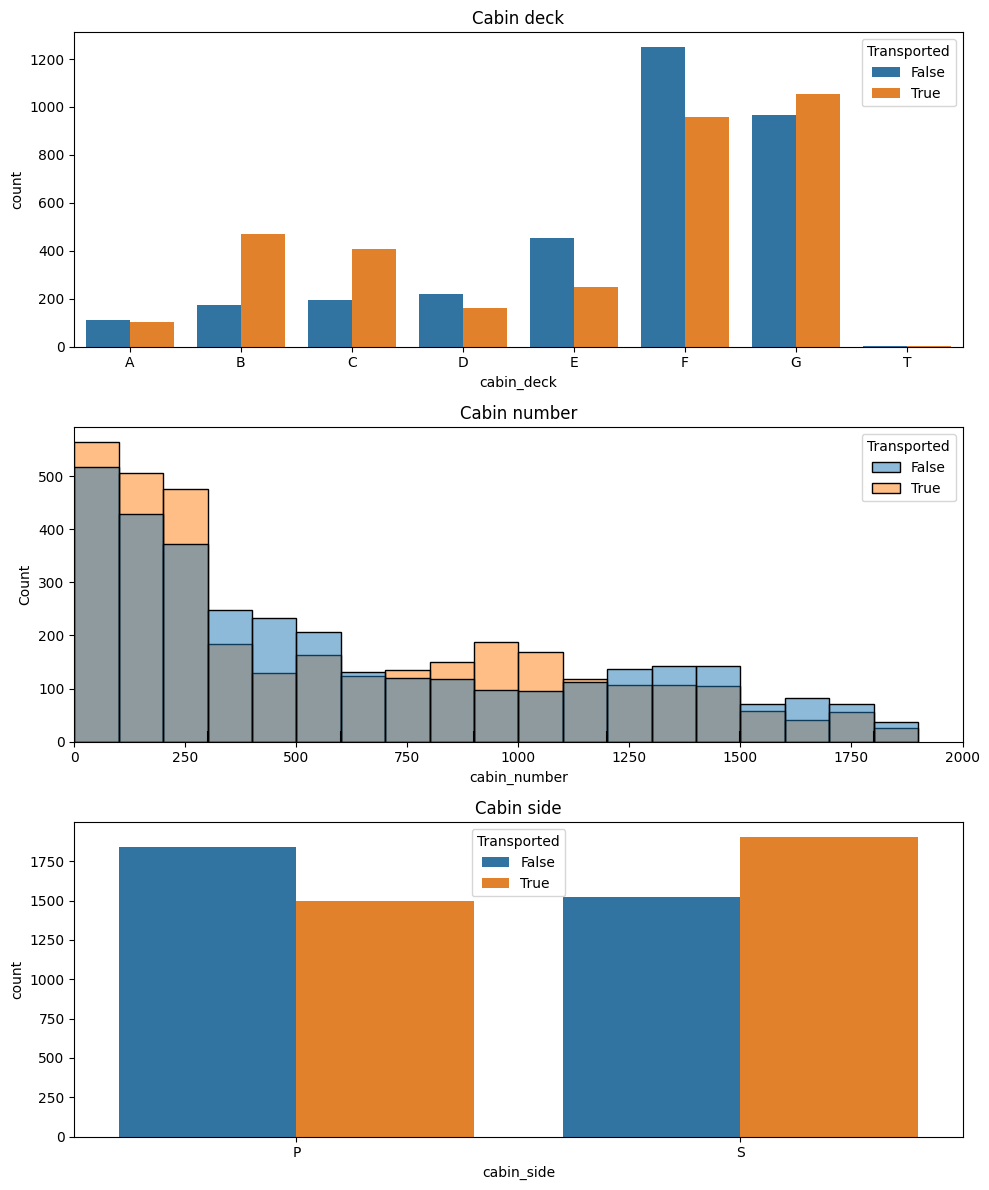

In [175]:
# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train_df, x='cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train_df, x='cabin_number', hue='Transported',binwidth=100)
plt.vlines(300, ymin=0, ymax=20, color='black')
plt.vlines(600, ymin=0, ymax=20, color='black')
plt.vlines(900, ymin=0, ymax=20, color='black')
plt.vlines(1200, ymin=0, ymax=20, color='black')
plt.vlines(1500, ymin=0, ymax=20, color='black')
plt.vlines(1800, ymin=0, ymax=20, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train_df, x='cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

In [176]:
display(train_df.describe())
display(train_df.dtypes)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_number
count,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000
mean,28.897398,224.415582,479.736251,180.495713,313.856298,304.565937,598.266854
std,14.529563,648.056361,1676.922138,638.032157,1138.989471,1126.895655,512.567208
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165.750000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,423.500000
75%,38.000000,51.000000,82.000000,30.250000,66.250000,52.000000,994.000000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,20336.000000,1894.000000


PassengerId      object
HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
cabin_deck       object
cabin_number      int64
cabin_side       object
age_group        object
dtype: object

In [177]:
def binningCabinRegion(dataset):
    dataset['cabin_region1']=(dataset['cabin_number']<300).astype(int)   # one-hot encoding
    dataset['cabin_region2']=((dataset['cabin_number']>=300) & (dataset['cabin_number']<600)).astype(int)
    dataset['cabin_region3']=((dataset['cabin_number']>=600) & (dataset['cabin_number']<900)).astype(int)
    dataset['cabin_region4']=((dataset['cabin_number']>=900) & (dataset['cabin_number']<1200)).astype(int)
    dataset['cabin_region5']=((dataset['cabin_number']>=1200) & (dataset['cabin_number']<1500)).astype(int)
    dataset['cabin_region6']=(dataset['cabin_number']>=1500).astype(int)

binningCabinRegion(train_df)
binningCabinRegion(test_df)

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,cabin_deck,cabin_number,cabin_side,age_group,cabin_region1,cabin_region2,cabin_region3,cabin_region4,cabin_region5,cabin_region6
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,B,0,P,Age_31-50,1,0,0,0,0,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,F,0,S,Age_18-25,1,0,0,0,0,0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,A,0,S,Age_51+,1,0,0,0,0,0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,A,0,S,Age_31-50,1,0,0,0,0,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,F,1,S,Age_13-17,1,0,0,0,0,0


In [178]:
def oneHotEncoding(dataset):
    return pd.get_dummies(dataset, columns=['HomePlanet', 'Destination', 'cabin_deck', 'cabin_side', 'age_group'])

train_df = oneHotEncoding(train_df)
test_df = oneHotEncoding(test_df)

train_df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,cabin_deck_G,cabin_deck_T,cabin_side_P,cabin_side_S,age_group_Age_0-12,age_group_Age_13-17,age_group_Age_18-25,age_group_Age_26-30,age_group_Age_31-50,age_group_Age_51+
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,...,False,False,True,False,False,False,False,False,True,False
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,...,False,False,False,True,False,False,True,False,False,False
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,...,False,False,False,True,False,False,False,False,False,True
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,...,False,False,False,True,False,False,False,False,True,False
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,...,False,False,False,True,False,True,False,False,False,False


In [179]:
def convert2int(dataset):
    dataset['CryoSleep'] = dataset['CryoSleep'].astype('int')
    dataset['VIP'] = dataset['VIP'].astype('int')
    dataset['cabin_deck_G'] = dataset['cabin_deck_G'].astype('int')
    dataset['cabin_deck_T'] = dataset['cabin_deck_T'].astype('int')
    dataset['cabin_side_P'] = dataset['cabin_side_P'].astype('int')
    dataset['cabin_side_S'] = dataset['cabin_side_S'].astype('int')
    dataset['age_group_Age_0-12'] = dataset['age_group_Age_0-12'].astype('int')
    dataset['age_group_Age_13-17'] = dataset['age_group_Age_13-17'].astype('int')
    dataset['age_group_Age_18-25'] = dataset['age_group_Age_18-25'].astype('int')
    dataset['age_group_Age_26-30'] = dataset['age_group_Age_26-30'].astype('int')
    dataset['age_group_Age_31-50'] = dataset['age_group_Age_31-50'].astype('int')
    dataset['age_group_Age_51+'] = dataset['age_group_Age_51+'].astype('int')

convert2int(train_df)
train_df['Transported'] = train_df['Transported'].astype('int')

convert2int(test_df)

train_df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,cabin_deck_G,cabin_deck_T,cabin_side_P,cabin_side_S,age_group_Age_0-12,age_group_Age_13-17,age_group_Age_18-25,age_group_Age_26-30,age_group_Age_31-50,age_group_Age_51+
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,1,0,0,0,0,0,1,0
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,...,0,0,0,1,0,0,1,0,0,0
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,...,0,0,0,1,0,0,0,0,0,1
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,...,0,0,0,1,0,0,0,0,1,0
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,...,0,0,0,1,0,1,0,0,0,0


In [180]:
from sklearn.preprocessing import MinMaxScaler

def minMaxScaling(dataset):
    scaler = MinMaxScaler()
    dataset['RoomService'] = scaler.fit_transform(dataset[['RoomService']])
    dataset['FoodCourt'] = scaler.fit_transform(dataset[['FoodCourt']])
    dataset['ShoppingMall'] = scaler.fit_transform(dataset[['ShoppingMall']])
    dataset['Spa'] = scaler.fit_transform(dataset[['Spa']])
    dataset['VRDeck'] = scaler.fit_transform(dataset[['VRDeck']])

def normalization(dataset):
    dataset['RoomService'] = np.log(dataset['RoomService'])
    dataset['FoodCourt'] = np.log(dataset['FoodCourt'])
    dataset['ShoppingMall'] = np.log(dataset['ShoppingMall'])
    dataset['Spa'] = np.log(dataset['Spa'])
    dataset['VRDeck'] = np.log(dataset['VRDeck'])
    dataset.replace(-np.inf, 0, inplace=True)
    minMaxScaling(dataset)

normalization(train_df)
normalization(test_df)

train_df.describe()


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_number,...,cabin_deck_G,cabin_deck_T,cabin_side_P,cabin_side_S,age_group_Age_0-12,age_group_Age_13-17,age_group_Age_18-25,age_group_Age_26-30,age_group_Age_31-50,age_group_Age_51+
count,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,...,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.00000,6764.000000,6764.000000
mean,0.351863,28.897398,0.024246,0.191499,0.189200,0.162176,0.187596,0.180851,0.502809,598.266854,...,0.298492,0.000444,0.493643,0.506357,0.095062,0.085305,0.275133,0.14178,0.315494,0.087226
std,0.477587,14.529563,0.153823,0.298305,0.288911,0.259150,0.280239,0.279908,0.500029,512.567208,...,0.457630,0.021057,0.499997,0.499997,0.293322,0.279355,0.446614,0.34885,0.464747,0.282188
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,423.500000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,38.000000,0.000000,0.427265,0.427725,0.338757,0.418623,0.398305,1.000000,994.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,1.000000,0.000000
max,1.000000,79.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1894.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [181]:
train_df.drop(columns=['PassengerId', 'Age'], inplace=True)
test_df.drop(columns=['PassengerId', 'Age'], inplace=True)

In [182]:
# Create indices at the 80th and 90th percentiles
"""
number_samples = len(train_df)
index_80th = round(number_samples * 0.8)
index_100th = index_80th + round(number_samples * 0.2)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shuffled_dataset = train_df.sample(frac=1, random_state=100)
train_data = shuffled_dataset.iloc[0:index_80th]
validation_data = shuffled_dataset.iloc[index_80th:index_100th]"""

'\nnumber_samples = len(train_df)\nindex_80th = round(number_samples * 0.8)\nindex_100th = index_80th + round(number_samples * 0.2)\n\n# Randomize order and split into train, validation, and test with a .8, .1, .1 split\nshuffled_dataset = train_df.sample(frac=1, random_state=100)\ntrain_data = shuffled_dataset.iloc[0:index_80th]\nvalidation_data = shuffled_dataset.iloc[index_80th:index_100th]'

In [183]:
"""label_column = ['Transported']

train_features = train_data.drop(columns=label_column)
train_labels = train_data['Transported']
validation_features = validation_data.drop(columns=label_column)
validation_labels = validation_data['Transported']"""

"label_column = ['Transported']\n\ntrain_features = train_data.drop(columns=label_column)\ntrain_labels = train_data['Transported']\nvalidation_features = validation_data.drop(columns=label_column)\nvalidation_labels = validation_data['Transported']"

In [184]:
# train_data.head()

In [185]:
# Name of the features we'll train our model on.
input_features = [
    'CryoSleep',
    'VIP',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'cabin_deck_G',
    'cabin_deck_T',
    'cabin_side_P',
    'cabin_side_S',
    'age_group_Age_0-12',
    'age_group_Age_13-17',
    'age_group_Age_18-25',
    'age_group_Age_26-30',
    'age_group_Age_31-50',
    'age_group_Age_51+',
]

In [186]:
# train_features.head()

In [187]:
X = train_df.iloc[:,:-1]
y = train_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [188]:
kn =kn = KNeighborsClassifier()
kn.fit(X_train,y_train)

KNeighborsClassifier()

In [191]:
pred1 = kn.predict(X_test)

In [192]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,classification_report,confusion_matrix
print('Accuracy score:%f'%(accuracy_score(y_test, pred1)*100))

Accuracy score:89.800443
